In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
f_sig = "signal_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    #"QCD":"bkg_2018_QCD_TuneCP5_PSWeights_ejdR_rejection_IDcut.coffea", QCD doesn't make it to cut 13 here!
    "Top":"bkg_2018_Top_ejdR_rejection_IDcut.coffea",
    "DY":"bkg_2018_DY_ejdR_rejection_IDcut.coffea",
    "Diboson":"bkg_2018_Diboson_ejdR_rejection_IDcut.coffea",
    "Triboson":"bkg_2018_Triboson_ejdR_rejection_IDcut.coffea",
    "W+jets":"bkg_2018_WJets_ejdR_rejection_IDcut.coffea",
    "Z+jets":"bkg_2018_ZJets_ejdR_rejection_IDcut.coffea"
}
bkg_histos = {}
histograms = []
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['W+jets'][h]) == hist.Hist and bkg_histos['W+jets'][h].sum(flow=True).value > 0:
        bkg[h] = {b:bkg_histos[b][h][{"samp":sum}] for b in bkg_histos.keys()}

In [4]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [5]:
def plot(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7"):
    nb = len(bkg_histos.keys())
    hb = hist.Stack.from_dict({b:bkg[hname][b][cut,::rebin] for b in bkg_histos.keys()})
    varAx = hb.axes[-1]
    for delta in deltas:
        plt.figure(figsize=(16,4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for i,ct in enumerate(ctaus):
            plt.subplot(1,4,i+1)
            plt.title(r"$c\tau = {0}$ mm".format(ct))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            for m1 in m1s:
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][point,cut,::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=False)
            
            if logy:
                plt.yscale('log')
            plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            
            ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
            if i==0:
                plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)
        
        plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        plt.savefig(f"plots/histos/{hname}_delta{delta:.1f}.pdf")
        plt.tight_layout()

# Isolation

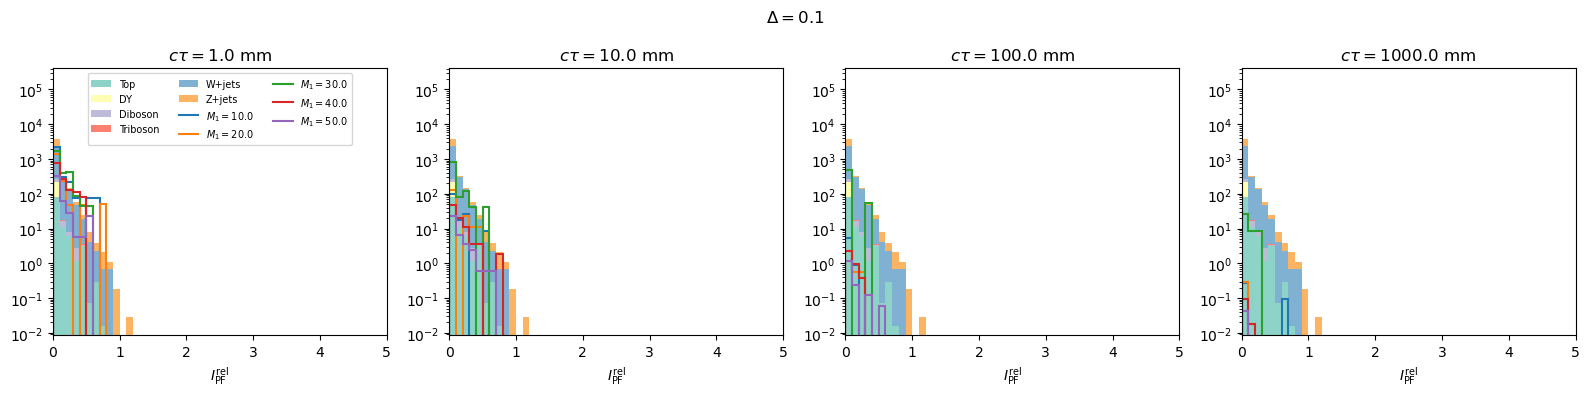

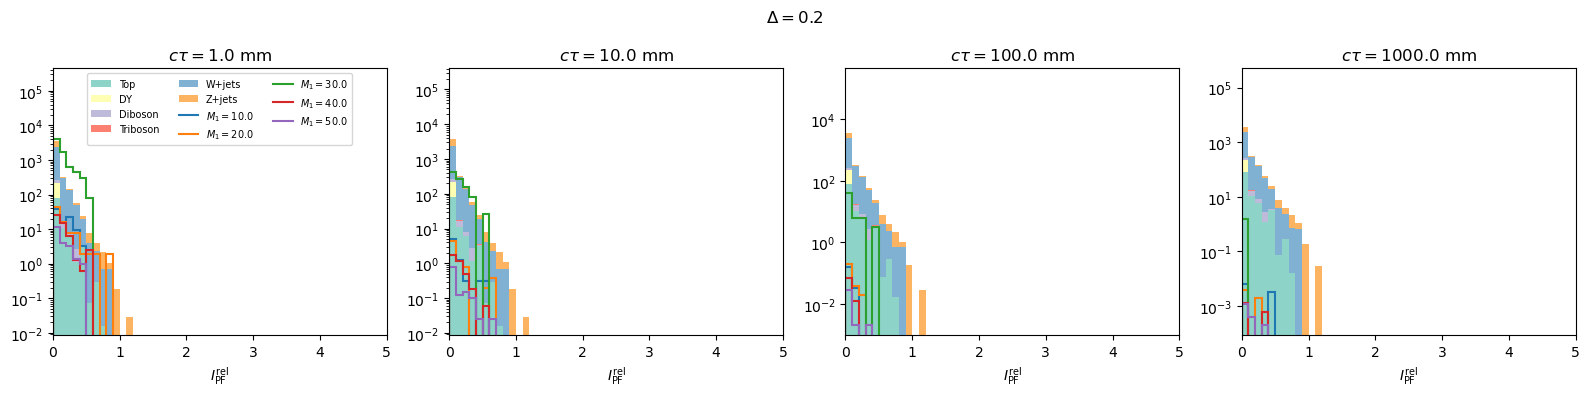

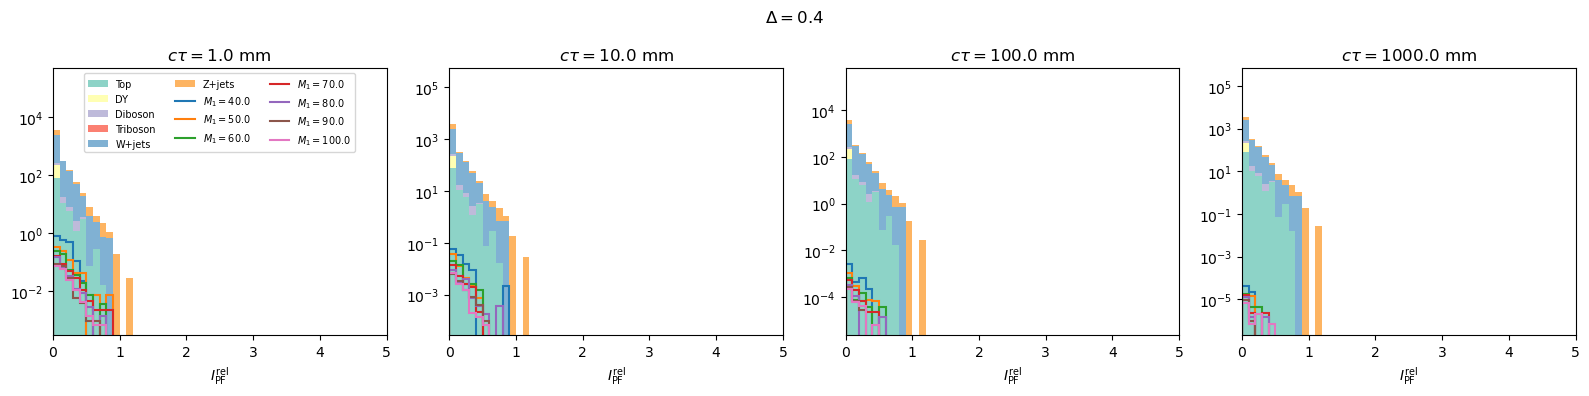

In [6]:
# vertex max PF isolation, using official PFIso for the electrons
plot("sel_vtx_maxPFIso",[0,5],logy=True,rebin=1j,xlabel="$I_\mathrm{PF}^\mathrm{rel}$",scaley=60)

# Displacement

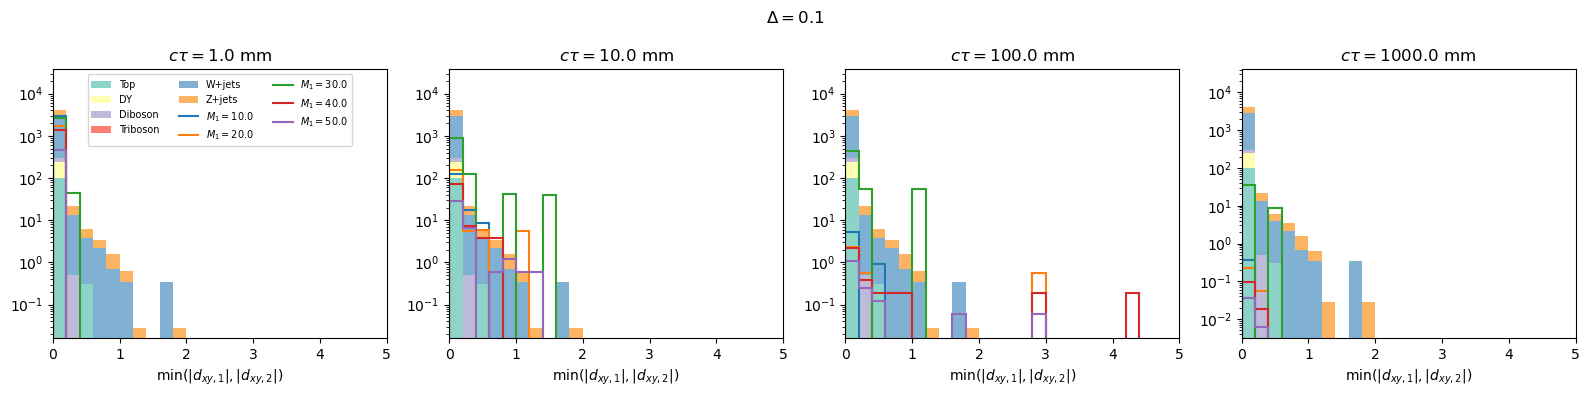

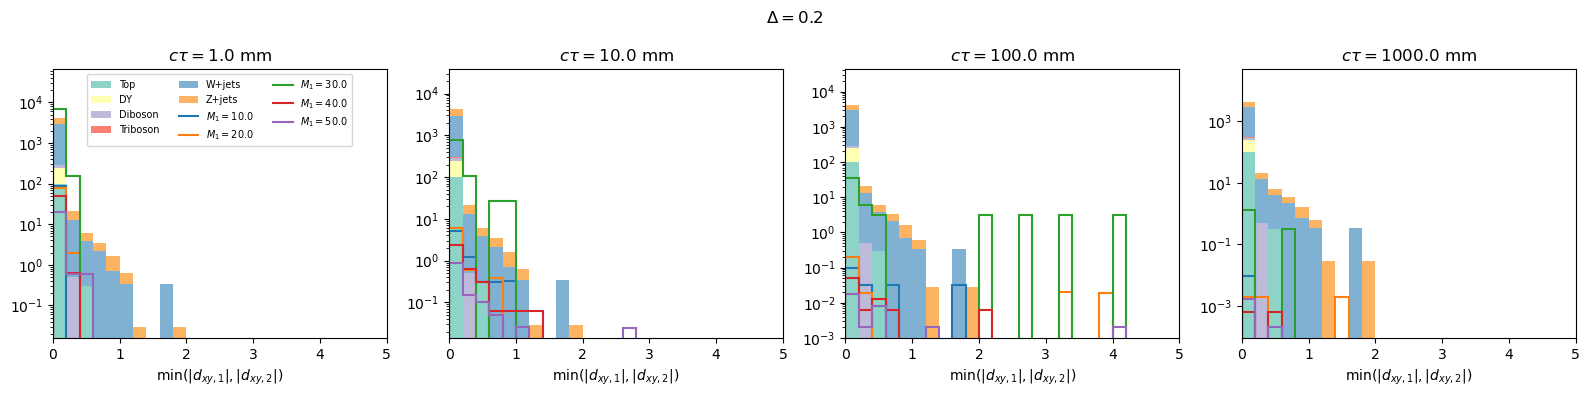

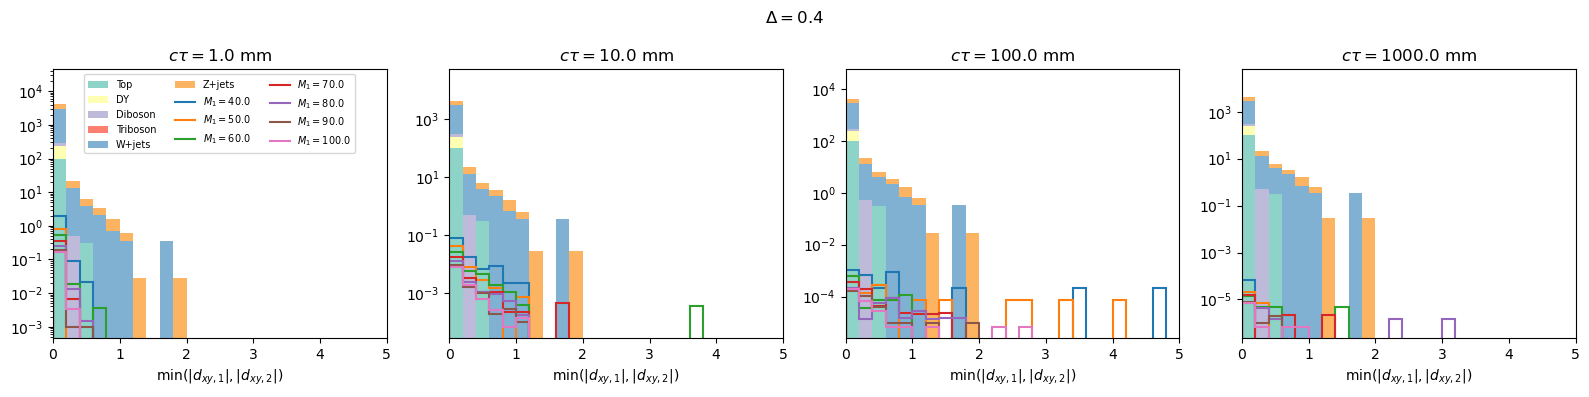

In [7]:
# vertex min(dxy1,dxy2)
plot("sel_vtx_minDxy",[0,5],logy=True,rebin=2j,xlabel="$\min(|d_{xy,1}|,|d_{xy,2}|)$")

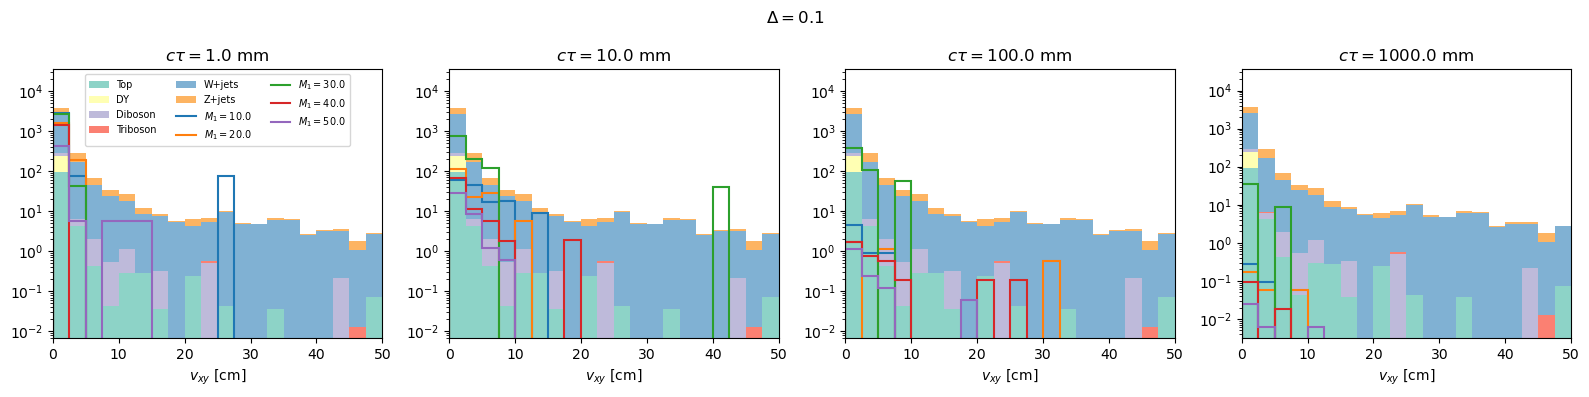

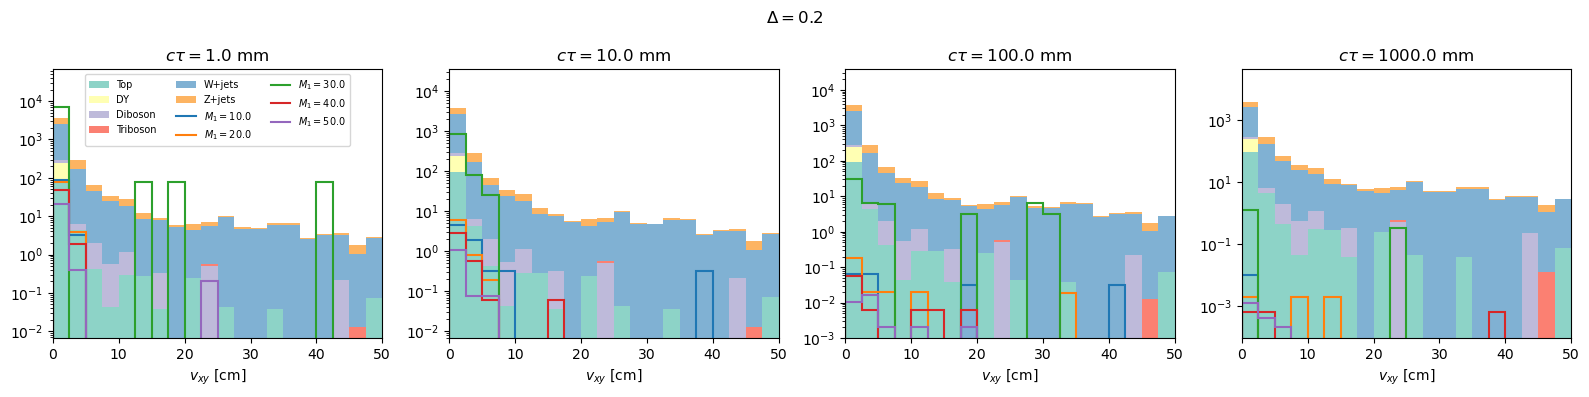

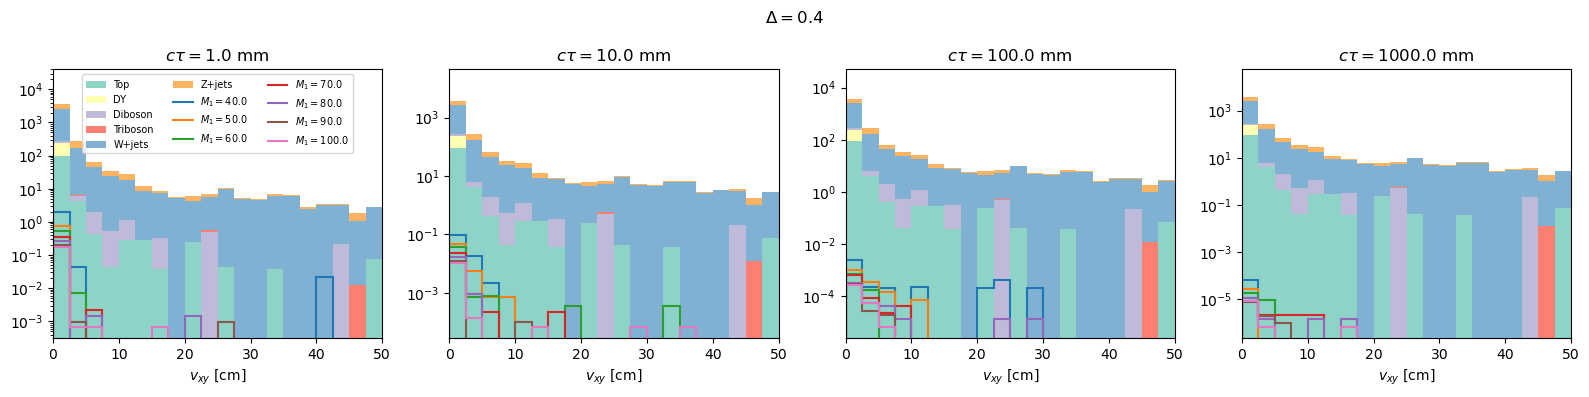

In [9]:
# vertex vxy
plot("sel_vtx_vxy",[0,50],logy=True,rebin=100j)

# Vertex dR

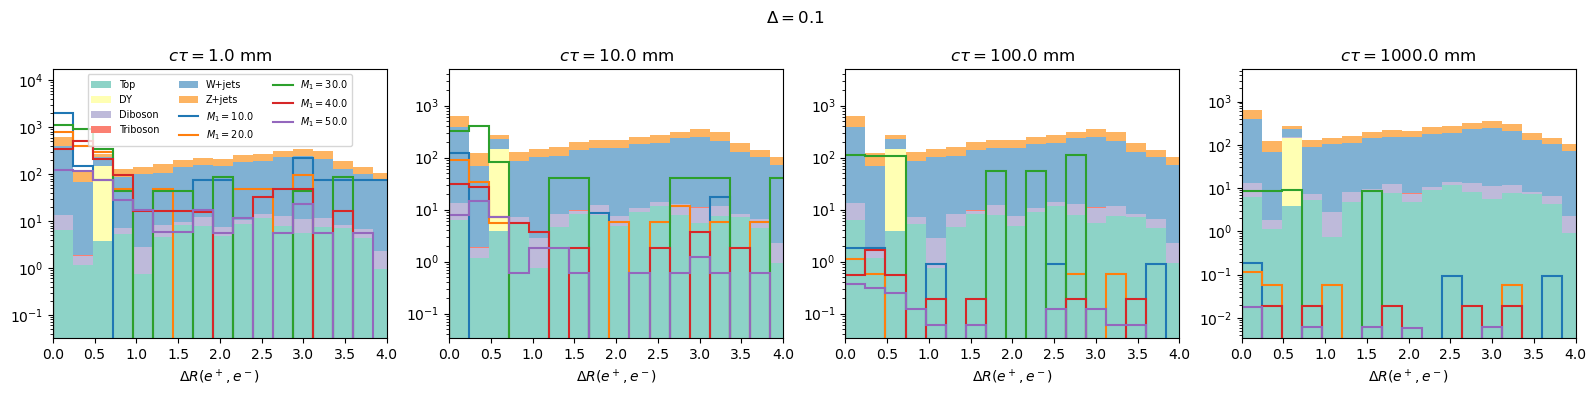

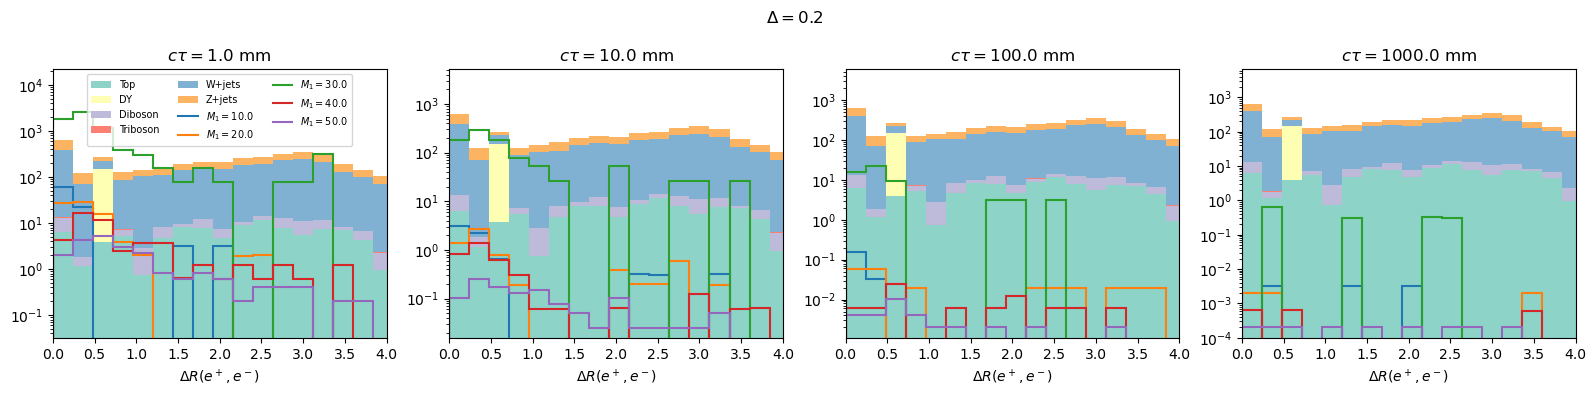

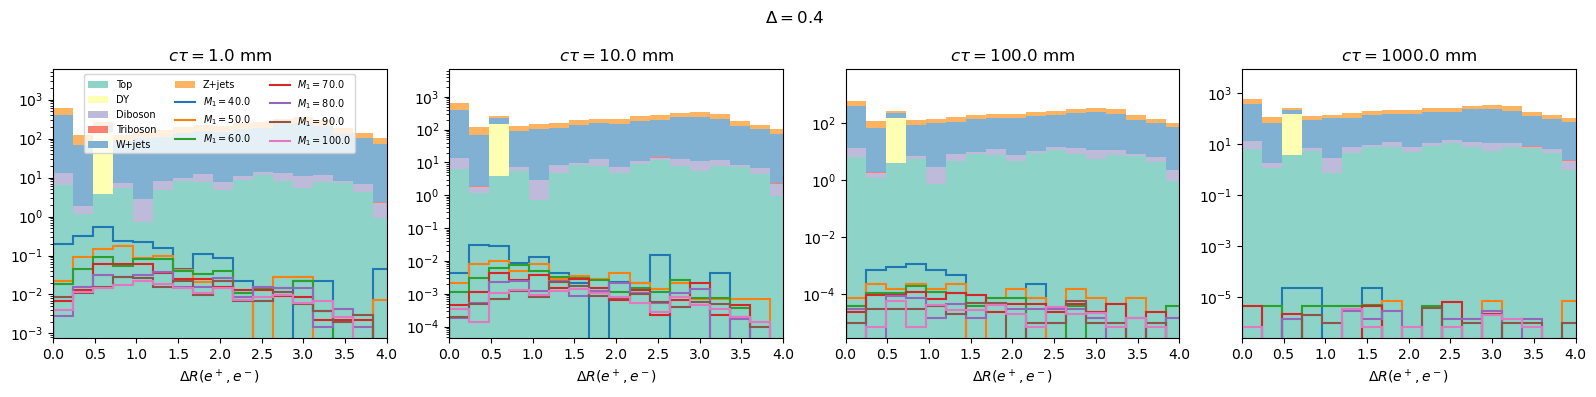

In [9]:
# vertex dR
plot("sel_vtx_dR",[0,4],logy=True,rebin=4j,xlabel="$\Delta R(e^+,e^-)$")

# Vertex-MET dPhi

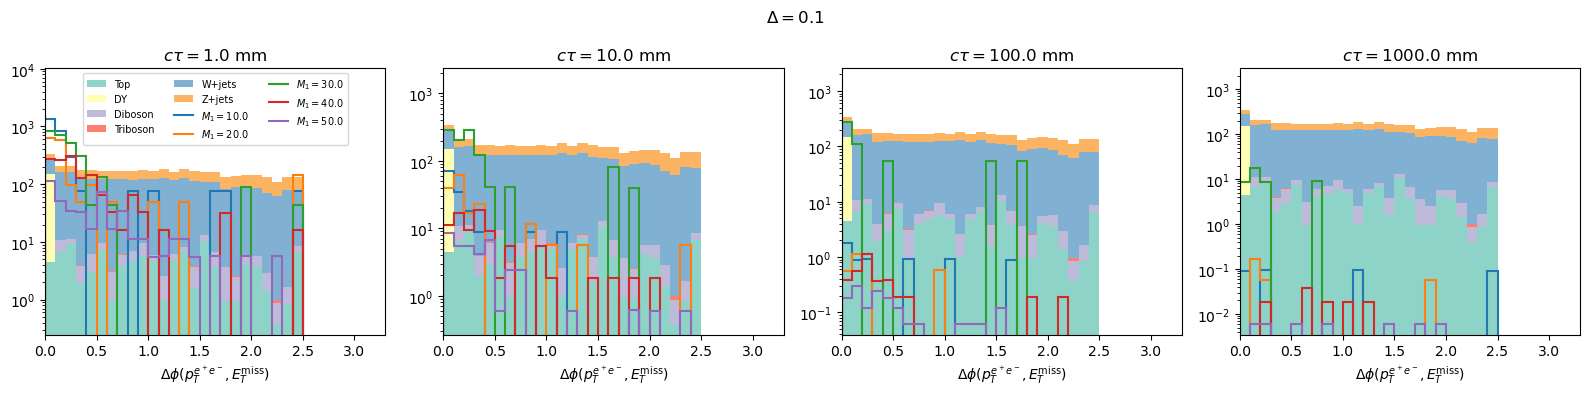

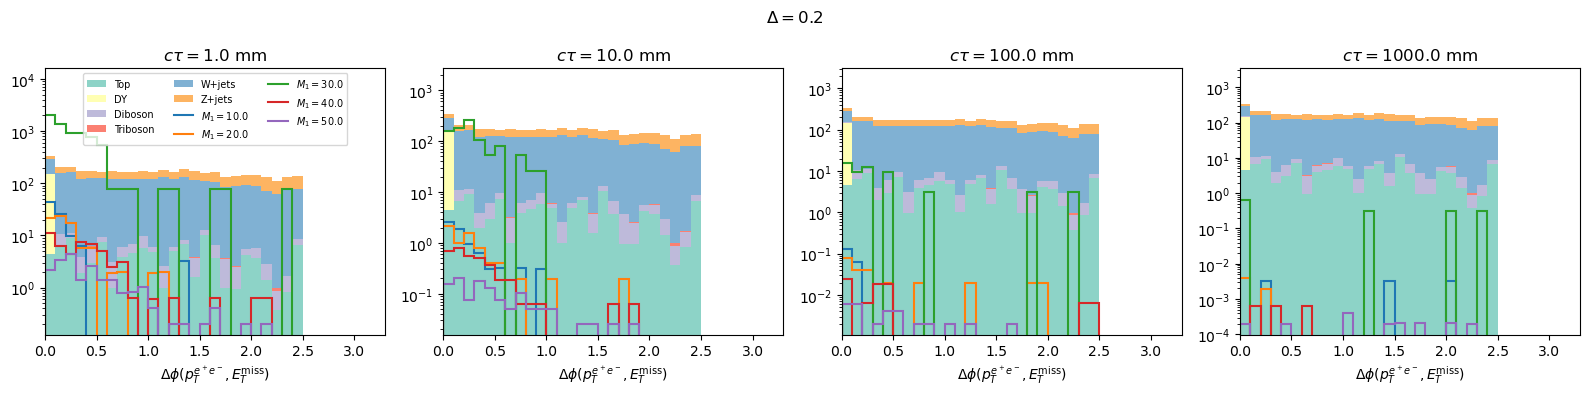

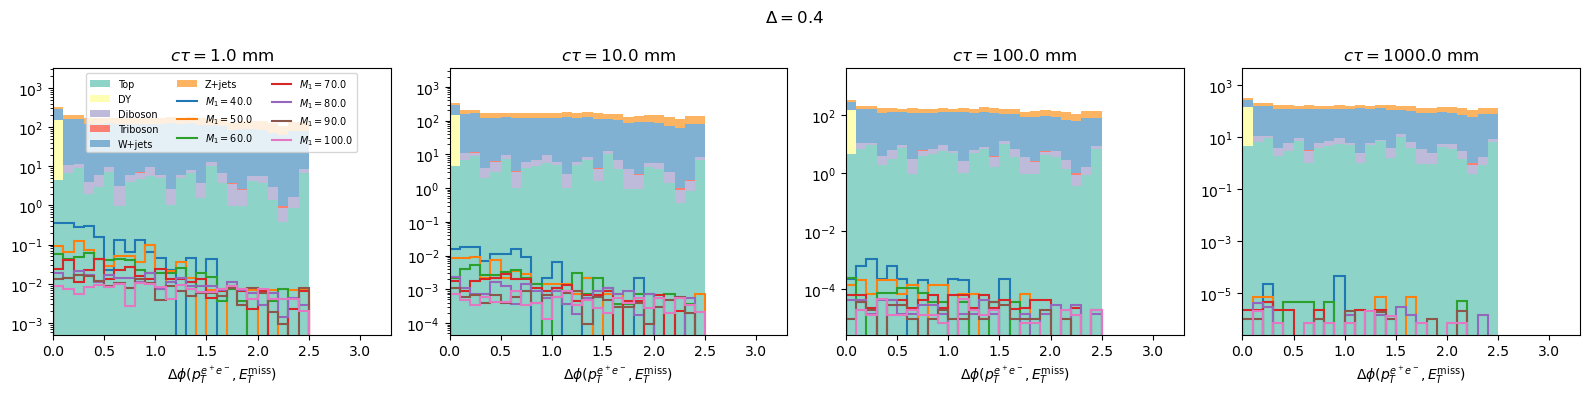

In [10]:
# vertex MET dPhi
plot("vtx_met_dPhi",[0,3.3],logy=True,rebin=2j,xlabel=r"$\Delta \phi(p_T^{e^+e^-},E_T^\mathrm{miss})$")

# Vertex Chi2

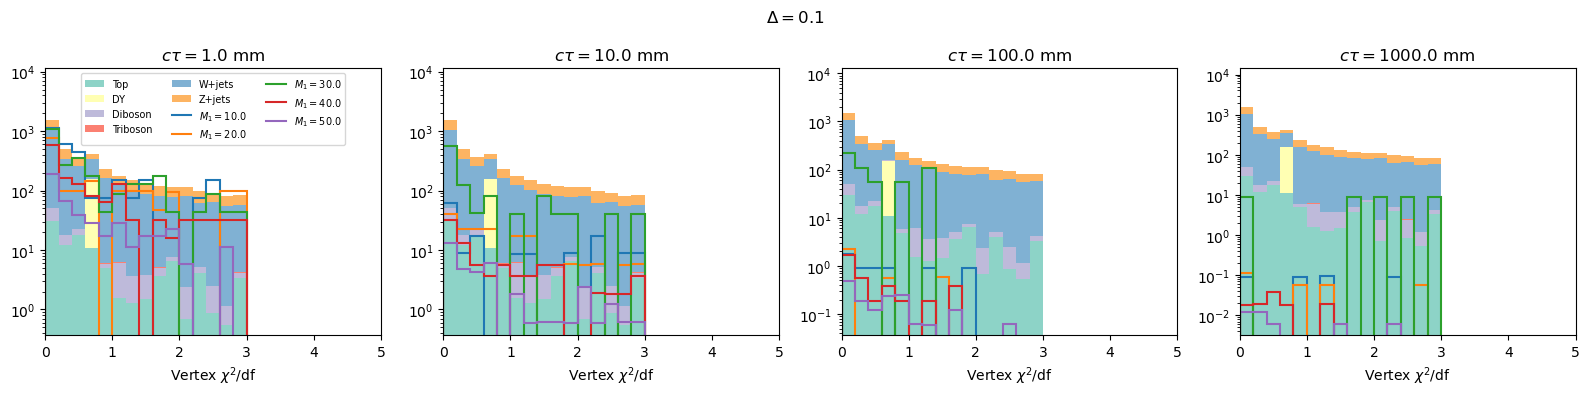

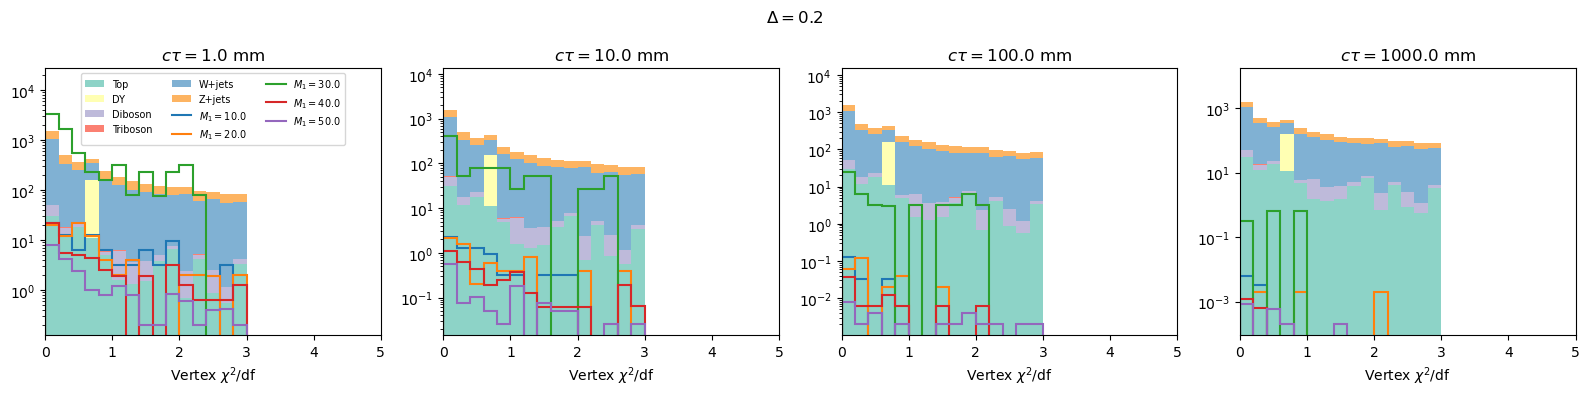

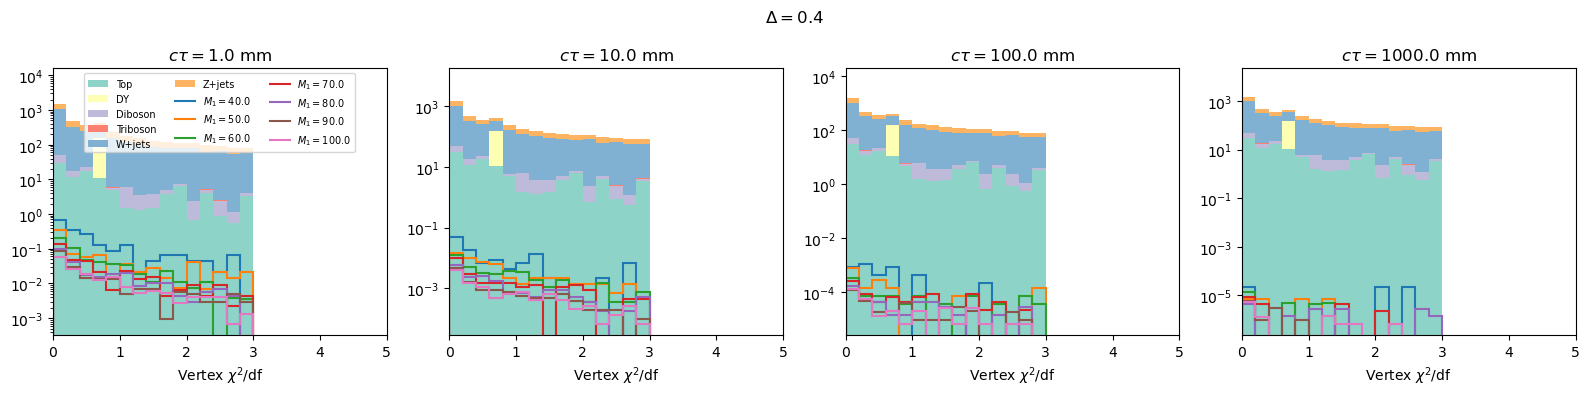

In [11]:
# vertex chi2
plot("sel_vtx_chi2",[0,5],logy=True,rebin=1j,xlabel="Vertex $\chi^2/\mathrm{df}$")

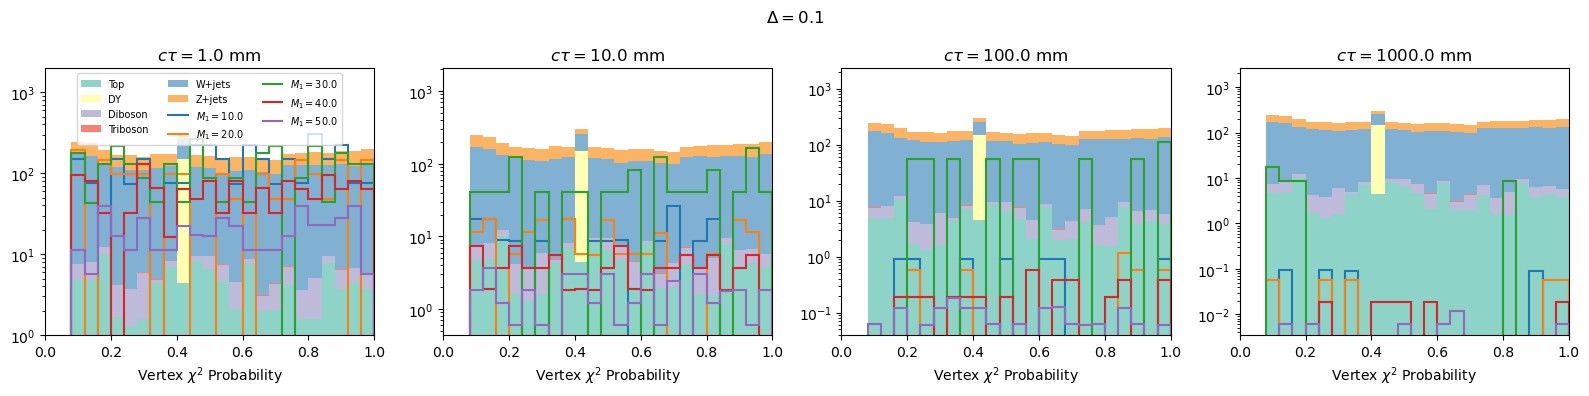

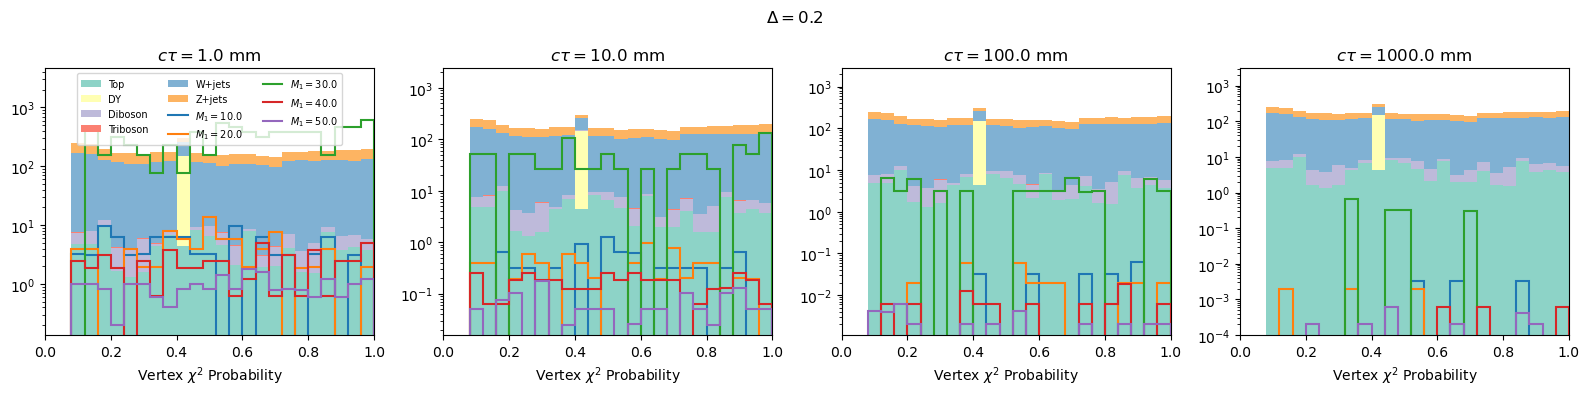

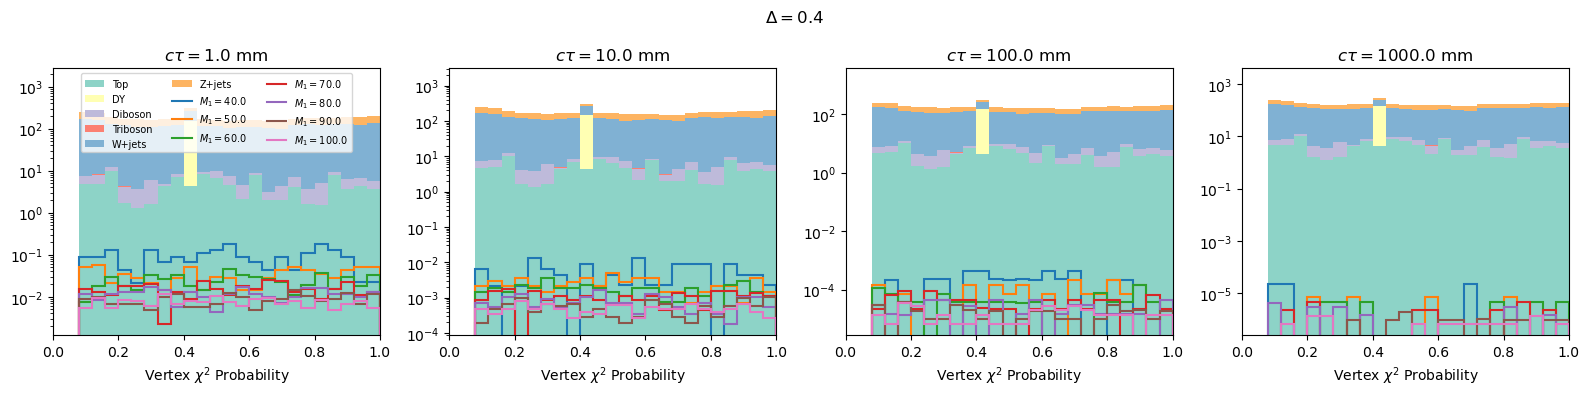

In [12]:
# vertex prob
plot("sel_vtx_prob",[0,1],logy=True,rebin=4j)

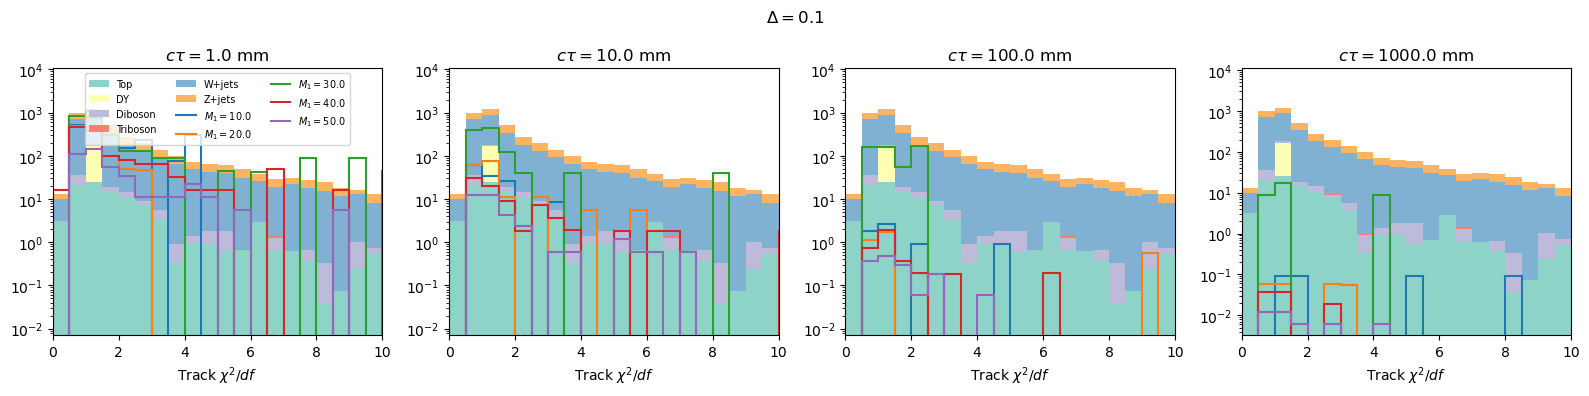

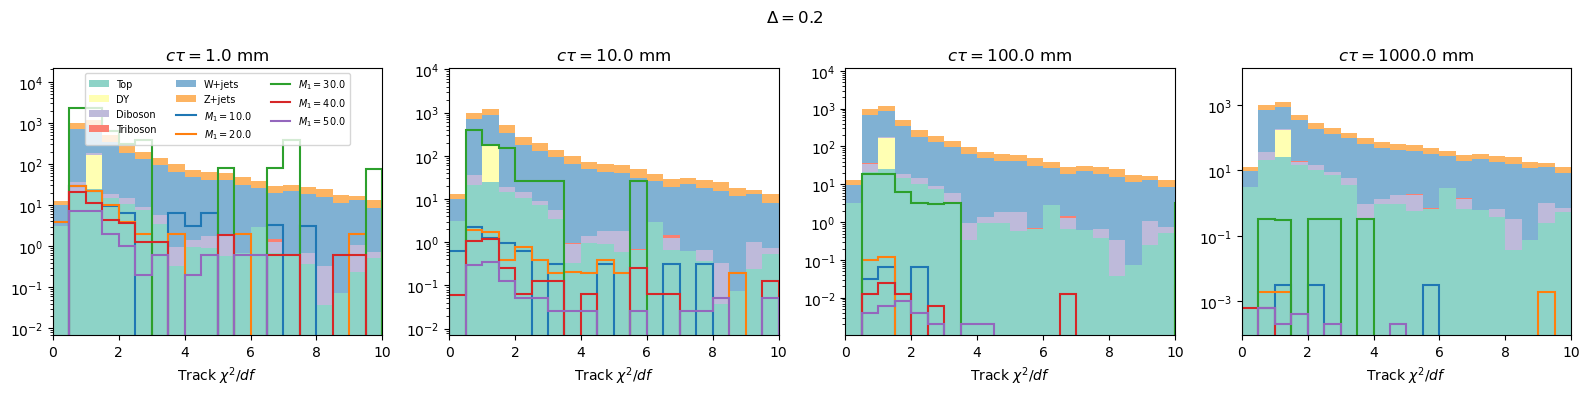

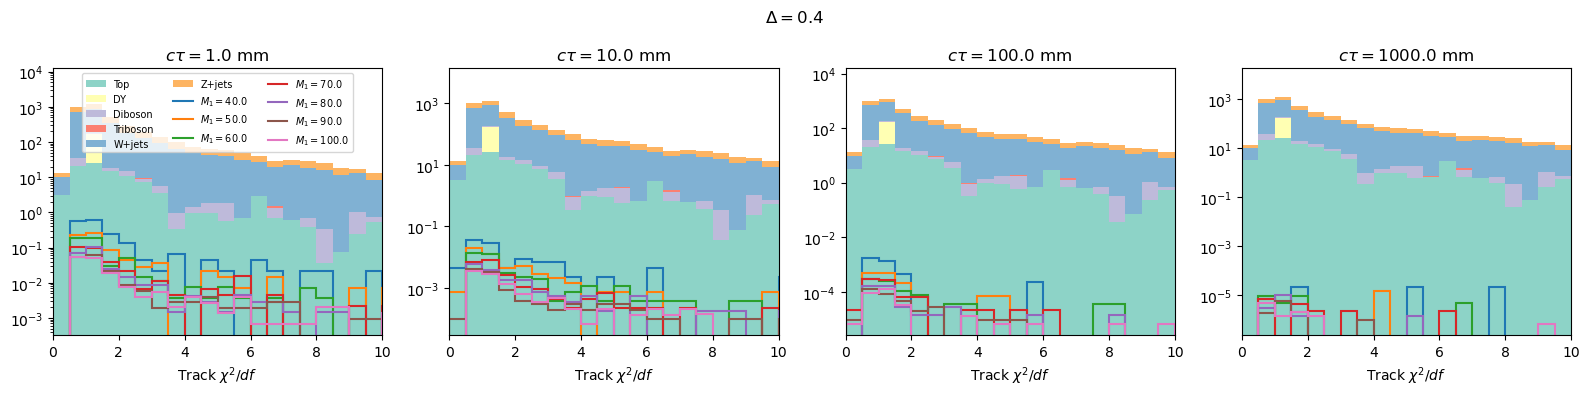

In [13]:
# vertex max(e1_chi2,e2_chi2)
plot("sel_vtx_max_chi2",[0,10],logy=True,rebin=1j)

# Electron-jet dR

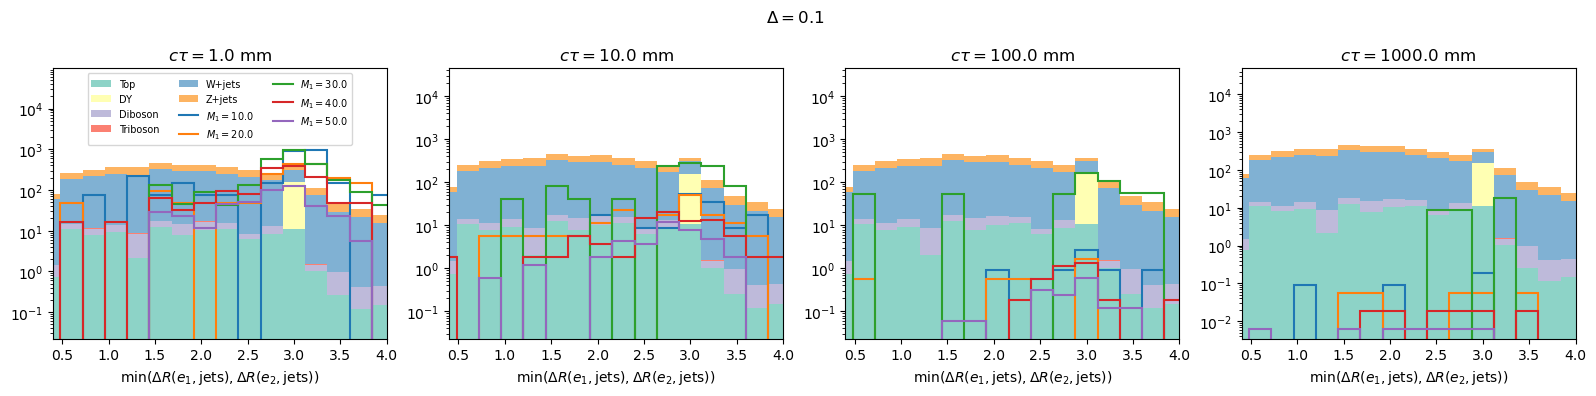

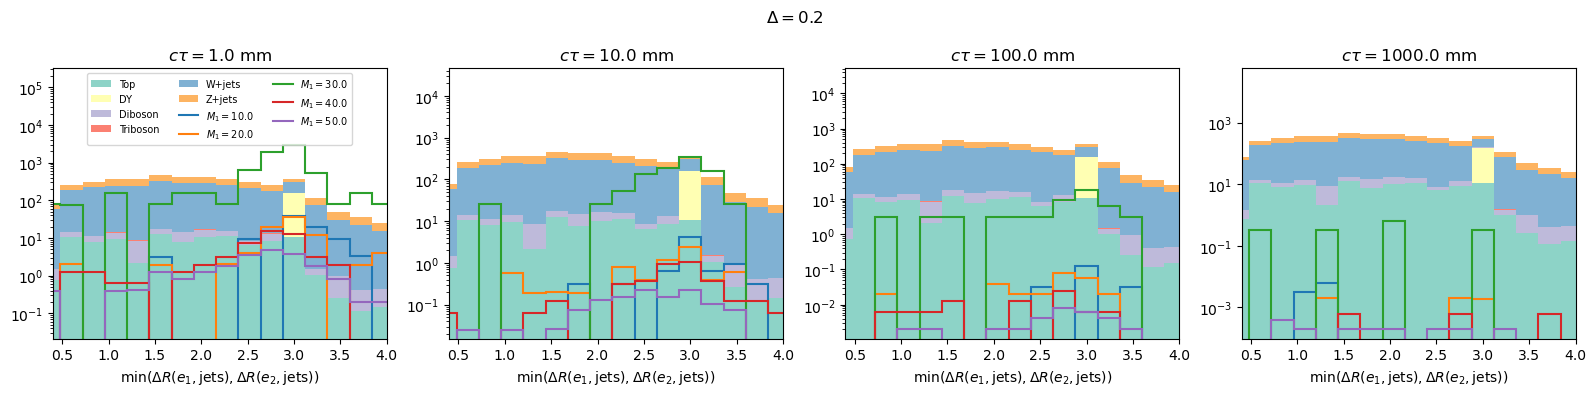

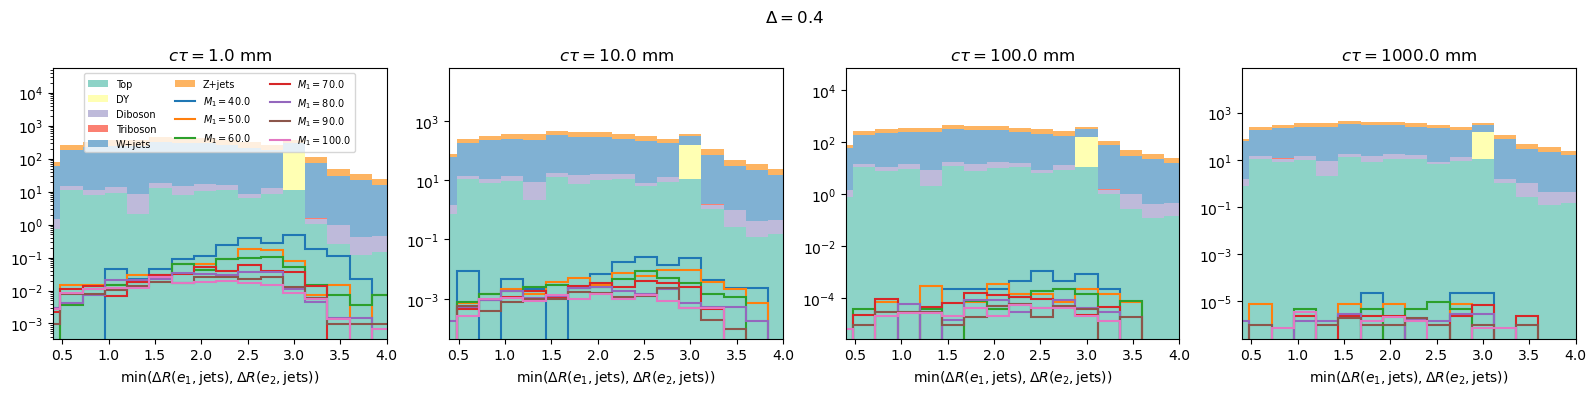

In [14]:
# mindR(vtx_eles,jets)
plot("sel_vtx_minEledRj",[0.4,4],logy=True,rebin=4j,scaley=60,xlabel="$\min(\Delta R(e_1,\mathrm{jets}),\Delta R(e_2,\mathrm{jets}))$")

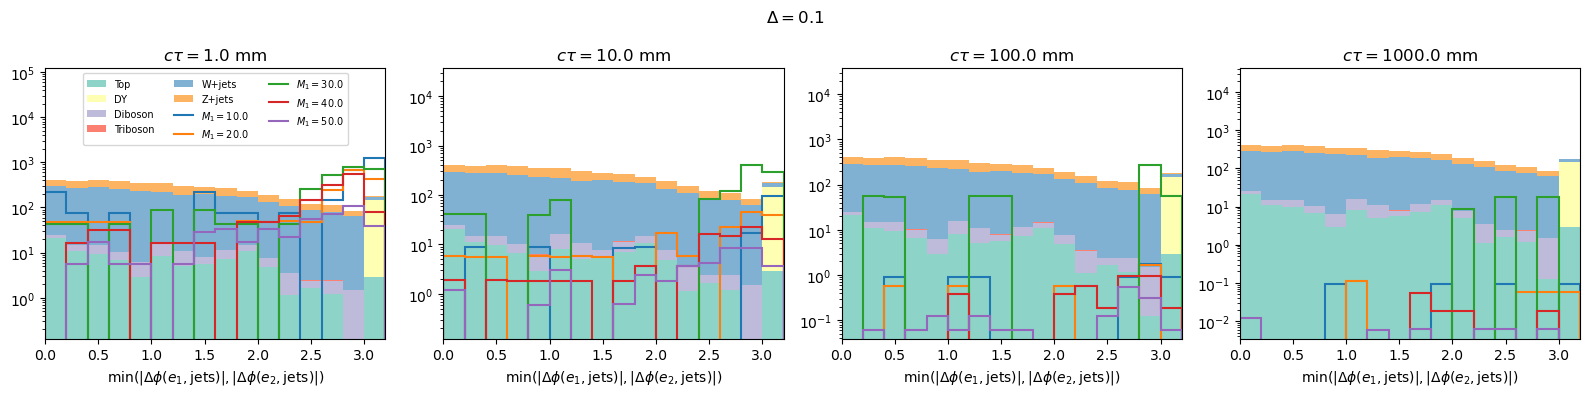

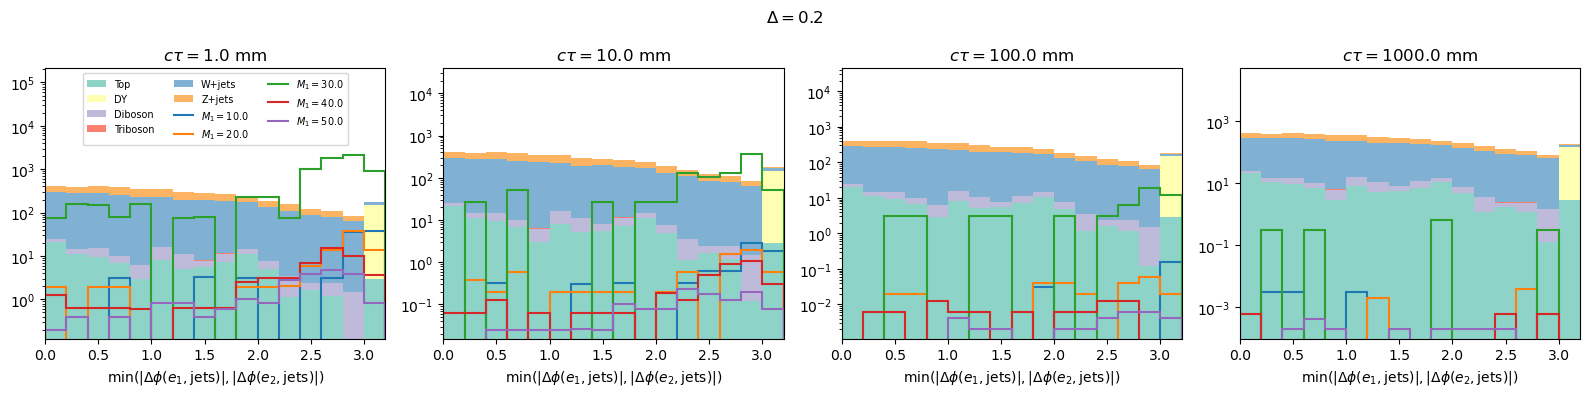

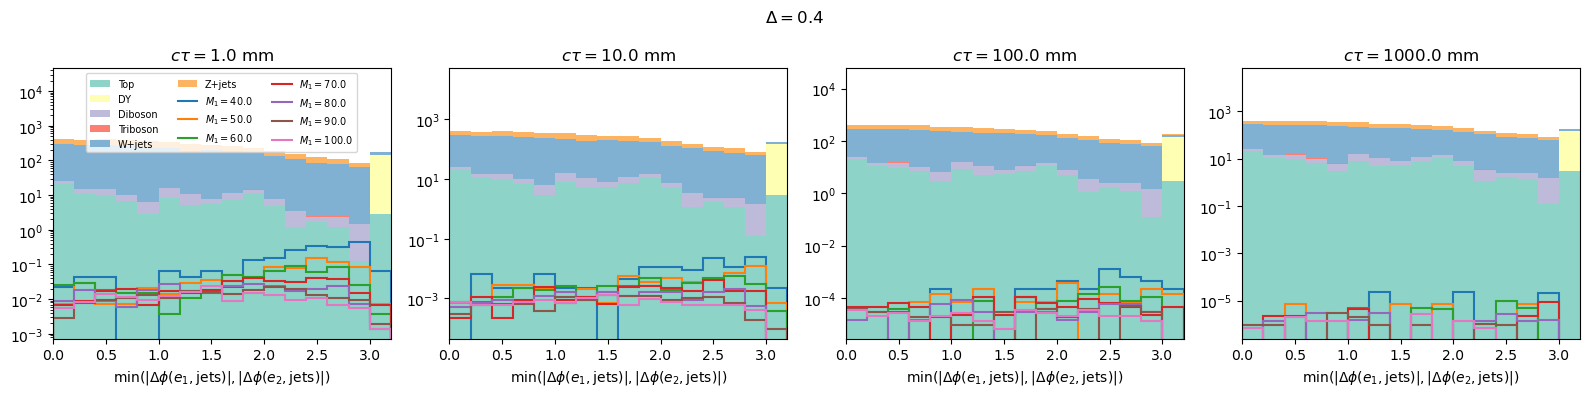

In [15]:
# mindPhi(vtx_eles,jets)
plot("sel_vtx_minEledPhiJ",[0,3.2],logy=True,rebin=2j,scaley=60,xlabel="$\min(|\Delta \phi(e_1,\mathrm{jets})|,|\Delta \phi(e_2,\mathrm{jets})|)$")

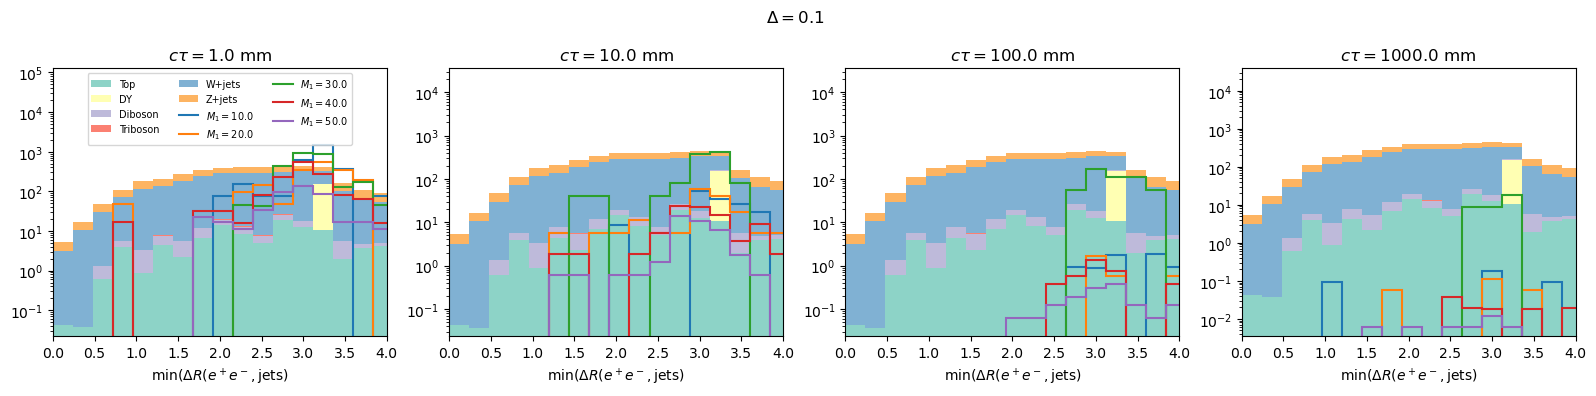

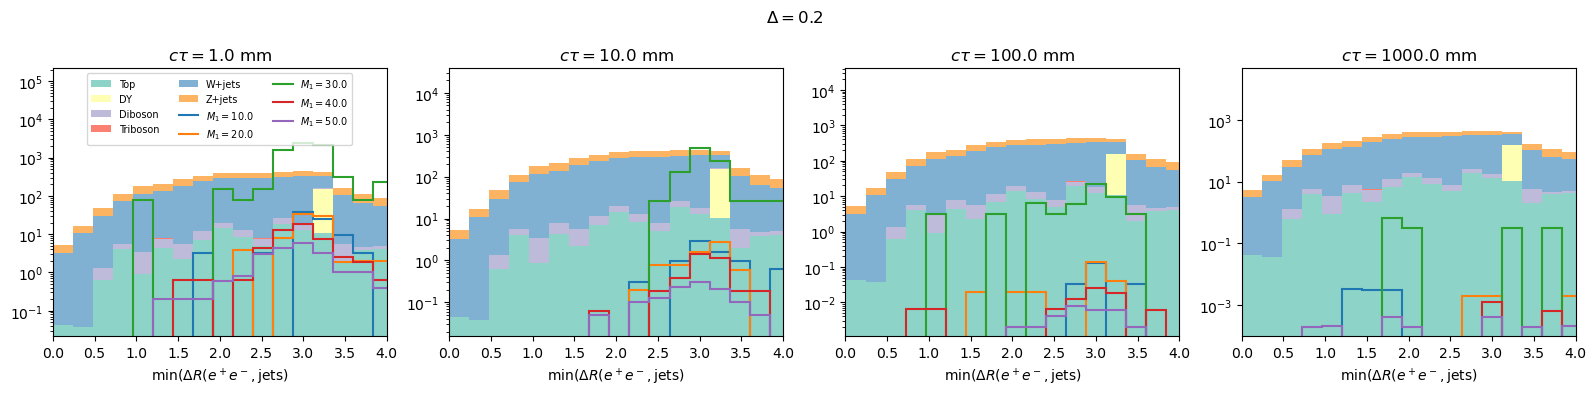

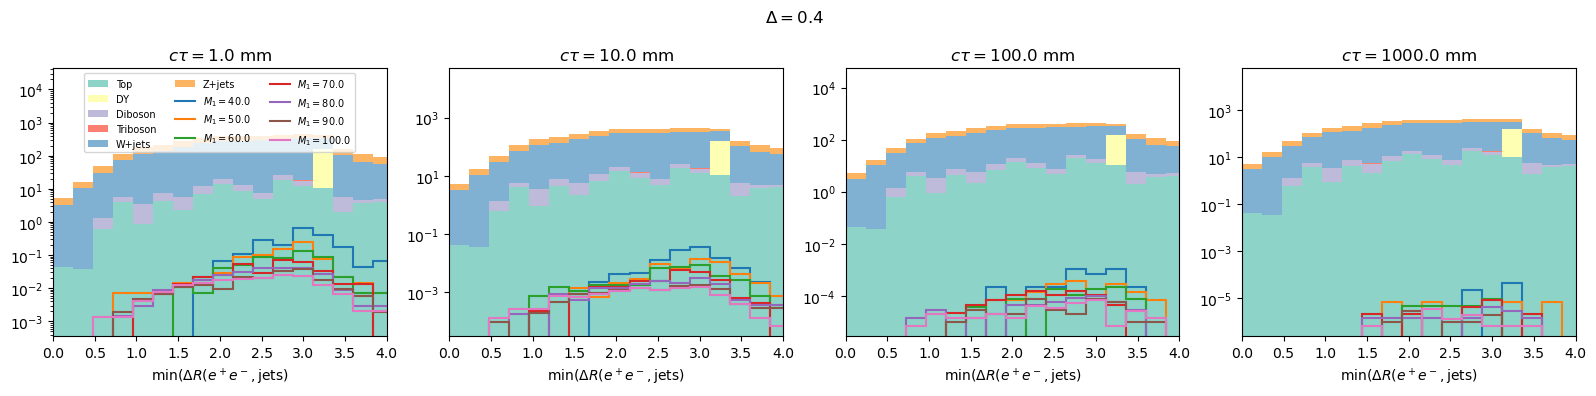

In [16]:
# mindR(vtx,jets)
plot("sel_vtx_mindRj",[0,4],logy=True,rebin=4j,scaley=50,xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets})$")

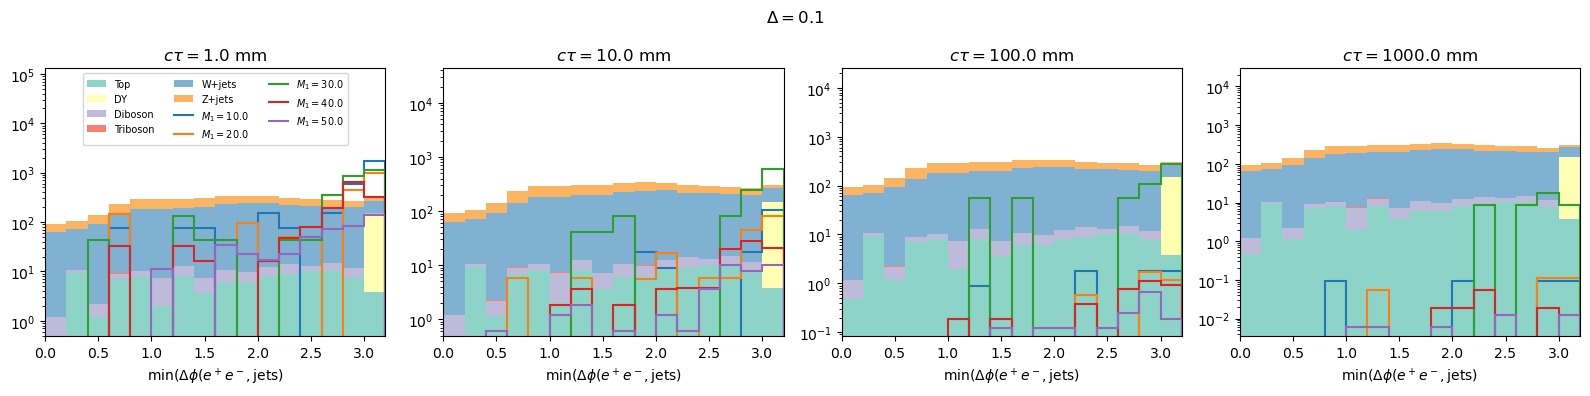

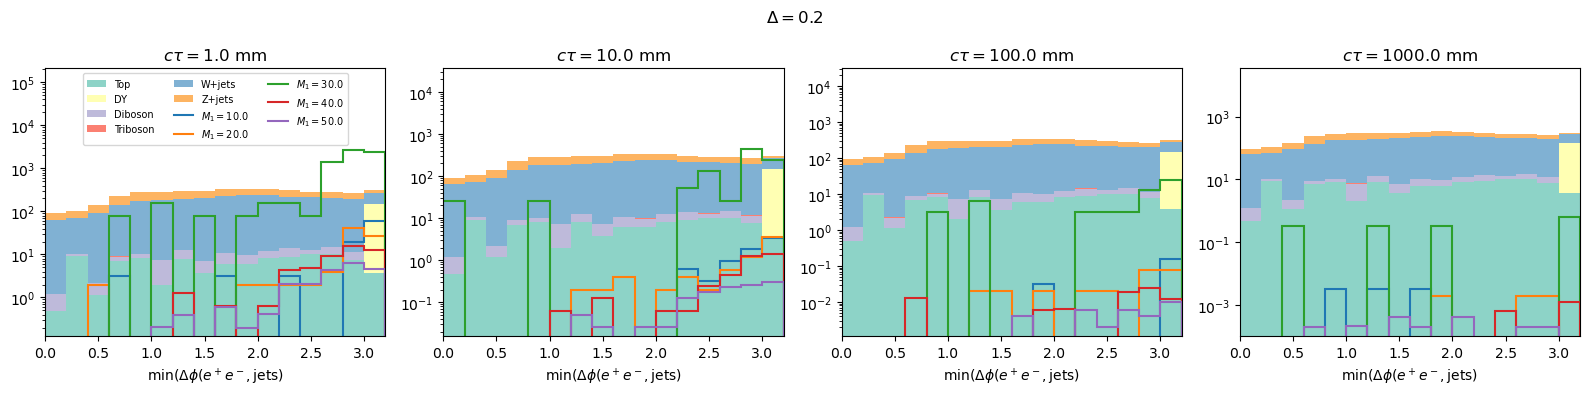

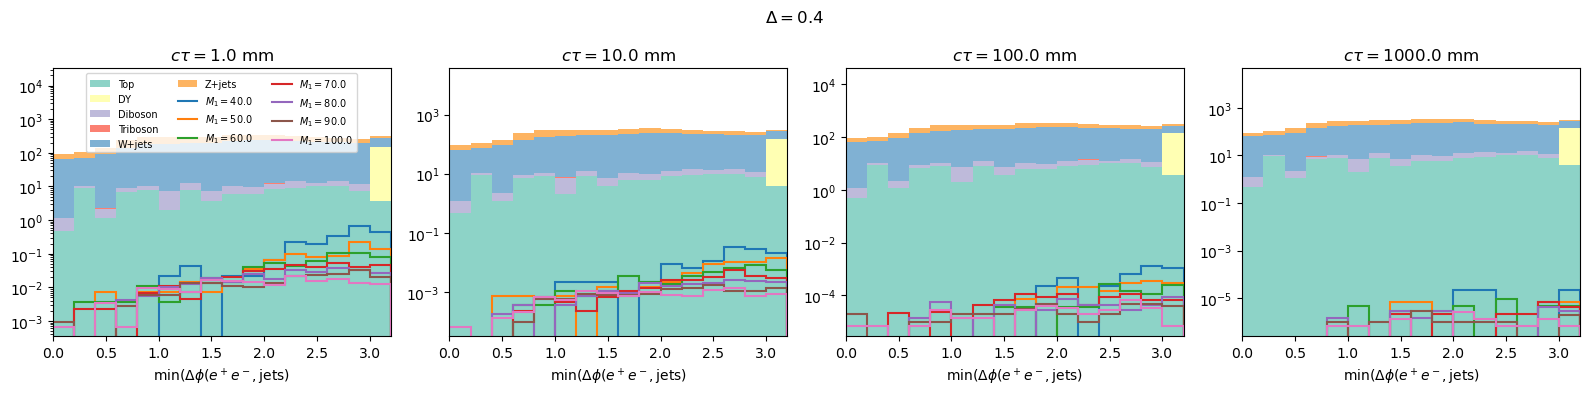

In [17]:
# mindPhi(vtx,jets)
plot("sel_vtx_mindPhiJ",[0,3.2],logy=True,rebin=2j,scaley=50,xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets})$")